<a href="https://colab.research.google.com/github/NelsonKamau/web-scraping/blob/main/Web_Scraping_for_Customer_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<center><u>Web Scraping for Customer Reviews</center></u>**



<center>-------------------------------------------------------------------</center>



## **Introduction**

### Objective
In order to better serve their customers, businesses must be aware of their feedback (Kumari et al., 2022). By collecting and analyzing `customer reviews`, businesses can learn about insightful trends among their customers and fine-tune their products and services. As a result, this project will involve the `scraping of customer reviews` for `DPD Ireland`, one of Ireland's leading `courier service` providers. The `scraped reviews dataset` will then be `cleaned`, and a few `exploratory data analysis` tasks will be performed on the dataset in order to make it suitable for `sentiment analysis` (Sahu et al., 2022).

## **Installing necessary packages**


`BeautifulSuop` has been installed in the following cell for use in our project.

In [ ]:
!pip3 install bs4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


`Kora.Selenium` has been installed in the following cell; this package is required to provide the `WD library`, which is required to request HTML pages from the server, which `BeautifulSoup` can then use.

In [ ]:
!pip3 install kora -q

     |████████████████████████████████| 57 kB 1.4 MB/s 
     |████████████████████████████████| 1.6 MB 9.8 MB/s 


## **Importing libraries**


The following libraries were used in this project:
- **Pandas** - for manipulating the scraped dataset 
- **BeautifulSoup**: to handle the HTML dom, after Selenium has requested data from the server,
- **Kora.Selenium**: Required so that we can use the WD library to ask the server to send the HTML frames from which we extracted the data.

In [ ]:
import sys
from time import sleep
import requests
import json
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import bs4
from kora.selenium import wd
from selenium.common.exceptions import NoSuchElementException
import re
import datetime as dt
import operator as op
import seaborn as sns                       #visualisation
import matplotlib.pyplot as plt             #visualisation
%matplotlib inline     
sns.set(color_codes=True)
from textblob import TextBlob, Word, Blobber

## **Necessary Functions**

The necessary classes and their inclusive functions are shown in this section. There are two classes: `Crawl`, which is used to scrape the dataset, and `pd_dataset`, which is used to format the scraped dataset.

In [ ]:
'''
  The main Class thats contains the website scraping methods
'''
class Crawl:
 
  def __init__(self, url):
    self.url = url

  # The below function captures the requred pages and returns their beautifulSoups
  def  page_capture(self):
    try:
      page = wd.get(self.url)
      soup = BeautifulSoup(wd.page_source)
    except Exception as e:
      print(e)

    return soup

  #The below function is used to scrape the text of the review body
  def scrape_text(self, soup, tag_name, attr_name, attr_value):
    contents_ = []

    if isinstance(soup, bs4.element.Tag):
      results = soup.find_all(tag_name, {attr_name:attr_value})
      for tag in results:
        for br in tag.find_all('br'):
          br.replace_with(' ')
        text = tag.find('p', {'data-service-review-text-typography':'true'})
        if text == None:
          contents_.append('NaN')
        else:
          contents_.append(''.join(text.contents))

      return contents_
    else:
      return 'Soup not a BeautifulSoup Object'

  # The following function is used to scrape the features of the review that can 
  # be scraped by using any of their attributes
  def scrape_by_attr(self, soup, tag_name, attr_name, attr_value):
    contents_ = []

    if isinstance(soup, bs4.element.Tag):
      result = soup.find_all(tag_name, {attr_name:attr_value})
      for tag in result:
        contents_.append(''.join(tag.contents))

      return contents_
    else:
      return 'Soup not a BeautifulSoup Object'

  # The below function is used to scrape hte review ratings specifically because it's 
  # has a different format when compared to the other attributes of the review
  def scrape_ratings(self, soup):
    contents_ = []
    if isinstance(soup, bs4.element.Tag):
      for tag in soup.find_all(alt=re.compile('Rated')):
        contents_.append(tag['alt'])

      return contents_
    else:
      return 'Soup not a BeautifulSoup Object'
      
  # The below function is used to scrape the data when the review was added to the website
  def date_stripper(self, soup, tag_name, attr_name, attr_value):
    contents_ = []
    if isinstance(soup, bs4.element.Tag):
      result = soup.find_all(tag_name, {attr_name:attr_value})
      for tag in result:
        tag.b.decompose()
        contents_.append(''.join(tag.contents).strip())

      return contents_
    else:
      return 'Soup not a BeautifulSoup Object'

  # The below function is used to scrape the data when the review was added to the website
  def country_stripper(self, soup, tag_name, attr_name, attr_value):
    contents_ = []
    if isinstance(soup, bs4.element.Tag):
      result = soup.find_all(tag_name, {attr_name:attr_value})
      for tag in result:
        tag.svg.decompose()
        contents_.append(''.join(tag.span.contents).strip())

      return contents_
    else:
      return 'Soup not a BeautifulSoup Object'


In [ ]:
'''
  Function to create DataFrame
'''
class pd_dataset:
  # Function to create the dataframe of the scraped data
  def func_data_frame_creator(self, data_container, columns_container):
    df = dict()
    if op.eq(len(data_container), len(columns_container)):
      for column, name in zip(data_container, columns_container):
        df[name] = column

      dataframe_ = pd.DataFrame.from_dict(df)
    
      return dataframe_
    else:
      return 'length of the dataset and columns names not equal'

  # The function below is used to split the review rating and select only the numerical value for the rating.
  def split_review_ratings(self, df_dataset):
    df_dataset['ReviewRatings(5)'] = [i.split()[1] for i in df_dataset['ReviewRatings(5)']]

    return df_dataset

  # The function below divides the review count into two parts, selects the numerical value of the count, and discards the remainder.
  def split_review_count(self, df_dataset):
    df_dataset['ReviewCount'] = [i.split()[0] for i in df_dataset['ReviewCount']]

    return df_dataset

  # The following function converts the data to the appropriate data type.
  def  dataType_formatter(self, df_dataset):
    try:
      dataset['ReviewDate'] = df_dataset['ReviewDate'].apply(lambda x: 
                                    dt.datetime.strptime(x,'%d %B %Y'))
      dataset['ReviewCount'] = dataset['ReviewCount'].astype('int')
      dataset['ReviewRatings(5)'] = dataset['ReviewRatings(5)'].astype('category')
      dataset['CustomerName'] = dataset['CustomerName'].astype('string')
      dataset['ReviewTitles'] = dataset['ReviewTitles'].astype('string')
      dataset['ReviewBody'] = dataset['ReviewBody'].astype('string')
    except ValueError as e:
      print(e)
    return df_dataset



## **Main Execution area**

This section contains the main area, in which an object of the `Crawl` class is created and then used to scrape the various features required from the selected websites. The class have various methods because different features necessitate using distinct tactics to scrape the features.

In [ ]:
#Attributes to be captured
custo_name = []
custo_loc = []
placeOf_origin = []
review_count = []
verified = []
review_ratings = []
review_titles = []
review_date = []
trip_type = []
review_text = []

for page in range(1, 200):
  try:
    #Creating the Crawling Object
    url = 'https://ie.trustpilot.com/review/www.dpd.ie?page='+str(page)
    objCrawl = Crawl(url)
    print(url)

    #Beautiful Soup Implementation
    soup = objCrawl.page_capture()
    main_review_block = soup.find('section', {'class' : 'styles_reviewsContainer__3_GQw'})
    rating_review_block = soup.find('div', {'class' : 'star-rating_starRating__4rrcf star-rating_medium__iN6Ty'})

    #Data scraping
    custo_name += objCrawl.scrape_by_attr(main_review_block, 'span', 'data-consumer-name-typography','true')
    custo_loc += objCrawl.country_stripper(main_review_block, 'div', 'data-consumer-country-typography','true')
    review_count += objCrawl.scrape_by_attr(main_review_block, 'span', 'data-consumer-reviews-count-typography','true')
    review_ratings += objCrawl.scrape_ratings(main_review_block)
    verified += objCrawl.scrape_by_attr(main_review_block, 'span', 'data-consumer-name-typography','true')
    review_titles += objCrawl.scrape_by_attr(main_review_block, 'h2', 'data-service-review-title-typography','true')
    review_date += objCrawl.date_stripper(main_review_block, 'p', 'data-service-review-date-of-experience-typography','true')
    review_text += objCrawl.scrape_text(main_review_block, 'div', 'data-review-content','true')
    
    
  except Exception as e:
    print(e)
    continue

https://ie.trustpilot.com/review/www.dpd.ie?page=1
https://ie.trustpilot.com/review/www.dpd.ie?page=2
https://ie.trustpilot.com/review/www.dpd.ie?page=3
https://ie.trustpilot.com/review/www.dpd.ie?page=4
https://ie.trustpilot.com/review/www.dpd.ie?page=5
https://ie.trustpilot.com/review/www.dpd.ie?page=6
https://ie.trustpilot.com/review/www.dpd.ie?page=7
https://ie.trustpilot.com/review/www.dpd.ie?page=8
https://ie.trustpilot.com/review/www.dpd.ie?page=9
https://ie.trustpilot.com/review/www.dpd.ie?page=10
https://ie.trustpilot.com/review/www.dpd.ie?page=11
https://ie.trustpilot.com/review/www.dpd.ie?page=12
https://ie.trustpilot.com/review/www.dpd.ie?page=13
https://ie.trustpilot.com/review/www.dpd.ie?page=14
https://ie.trustpilot.com/review/www.dpd.ie?page=15
https://ie.trustpilot.com/review/www.dpd.ie?page=16
https://ie.trustpilot.com/review/www.dpd.ie?page=17
https://ie.trustpilot.com/review/www.dpd.ie?page=18
https://ie.trustpilot.com/review/www.dpd.ie?page=19
https://ie.trustpilot

In [ ]:
# Displays the length of the scraped review's attributes
print(len(custo_name))
print(len(custo_loc))
print(len(review_count))
print(len(review_ratings))
print(len(review_titles))
print(len(review_date))
print(len(review_text))

3980
3980
3980
3980
3980
3980
3980




---


The cell below shows the final result of the scraped data from the `Crawl` class. Among the outcomes are:

*   `Customer Name`
*   `Customer Country of Origin`
*   `Reviews count per customer`
*   `Review ratings`
*   `Review titles`
*   `The review body text`





In [ ]:
print(custo_name)
print(custo_loc)
print(review_count)
print(review_ratings)
print(review_titles)
print(review_date)
print(review_text)

['Belle Condron', 'Regina Rochford', 'Niamh', 'Margaret Hayes', 'Jenny', 'Niamh Maher', 'June Fahy', 'Anna Stokes', 'Miriam Hickey', 'Kristina Whyte', 'PAULINE CRONIN', 'Ms. Lorna Wilson', 'Linda', 'Kellyann Dowie', 'Damien Moloney', 'Mags Ryder', 'Erica Prendergast', 'S Hudson', 'Aideen Bergin', "Cian O'Grady", 'Berni', 'Dani', 'Eileen ', 'Marie Gilligan', 'Danielle Whelan', 'CATHERINE WILLIAMS', 'Clare Finnegan', 'Dorothy Brown', 'Martina Mc Carrick', 'Yvonne Swift', 'John', 'El ', 'E B', 'Tracey', 'Carol McCarthy', 'Roisin Neely', 'Jade Dunne', 'Belinda Casey ', "Bryan O'Malley", 'Georgia Connelly', 'Georgia Connelly', 'Cora Regan', 'Mrs Marie Mooney', 'grainne', 'Mary Keaveney', 'Cliona Ryan', 'PAOLA DO CARMO', 'Joanne Conway', 'Shirley Hosford', 'Anna Fleming', 'Lynn Tuohy', 'Roisin', 'Brid O Leary', 'Karen Reilly', 'TINA Purcell', 'Miss Cathriona Mitchell', 'Mary Mangan', 'Elizabeth O Gorman', 'Anne Marie Cantwell', 'M gorman', 'Sandra Otoole', 'Maureen Kavanagh', 'MRS ELIZABETH 

If one looks closely, it is easy to see that the returned data is in an unformatted state. As a result, the following section is primarily concerned with formatting the data and creating an error-free `pandas dataframe`.

## **Data Munging**

The data is cleaned in this section, and any unnecessary dataset parts are removed.



---
### `Pandas DataFrame` creation

The scraped data is compiled into a `Pandas DataFrame` in the following cell, along with the necessary `column titles`.

In [ ]:
data = [custo_name, custo_loc, review_count, review_date, review_ratings, review_titles, review_text]
columns = ['CustomerName', 'Country', 'ReviewCount', 'ReviewDate', 'ReviewRatings(5)', 'ReviewTitles', 'ReviewBody']
objData = pd_dataset()

dataset = objData.func_data_frame_creator(data, columns)

dataset.head()

,CustomerName,Country,ReviewCount,ReviewDate,ReviewRatings(5),ReviewTitles,ReviewBody
0,Belle Condron,IE,1 review,10 December 2022,Rated 5 out of 5 stars,Speedy delivery,Speedy delivery. Very friendly and thoughtful ...
1,Regina Rochford,IE,1 review,10 December 2022,Rated 4 out of 5 stars,Ordered my item yesterday and it was…,Ordered my item yesterday and it was delivered...
2,Niamh,IE,7 reviews,02 December 2022,Rated 2 out of 5 stars,Collection didn't happen on the day…,Collection didn't happen on the day that was a...
3,Margaret Hayes,IE,5 reviews,10 December 2022,Rated 5 out of 5 stars,Totally dependable,I receive numerous packages from various retai...
4,Jenny,IE,1 review,07 November 2022,Rated 3 out of 5 stars,Text message saying what time the…,Text message saying what time the driver will ...


### Splitting the `ReviewRatings(5)`

It is clear from the above cell results that the `ReviewRatings(5)` column needs some formatting. As a result, the unnecessary data has been removed while the necessary `rating value` has remained.

In [ ]:
#Splitting the review ratings column
dataset = objData.split_review_ratings(dataset)
dataset.head()

,CustomerName,Country,ReviewCount,ReviewDate,ReviewRatings(5),ReviewTitles,ReviewBody
0,Belle Condron,IE,1 review,10 December 2022,5,Speedy delivery,Speedy delivery. Very friendly and thoughtful ...
1,Regina Rochford,IE,1 review,10 December 2022,4,Ordered my item yesterday and it was…,Ordered my item yesterday and it was delivered...
2,Niamh,IE,7 reviews,02 December 2022,2,Collection didn't happen on the day…,Collection didn't happen on the day that was a...
3,Margaret Hayes,IE,5 reviews,10 December 2022,5,Totally dependable,I receive numerous packages from various retai...
4,Jenny,IE,1 review,07 November 2022,3,Text message saying what time the…,Text message saying what time the driver will ...


### Splitting the `ReviewCount`

Also, the same formatting that was used for the ratings is required in the `ReviewCount` column with the intention of remining only with neumeric values.

In [ ]:
#Splitting the ReviewCount column
dataset = objData.split_review_count(dataset)
dataset.head()

,CustomerName,Country,ReviewCount,ReviewDate,ReviewRatings(5),ReviewTitles,ReviewBody
0,Belle Condron,IE,1,10 December 2022,5,Speedy delivery,Speedy delivery. Very friendly and thoughtful ...
1,Regina Rochford,IE,1,10 December 2022,4,Ordered my item yesterday and it was…,Ordered my item yesterday and it was delivered...
2,Niamh,IE,7,02 December 2022,2,Collection didn't happen on the day…,Collection didn't happen on the day that was a...
3,Margaret Hayes,IE,5,10 December 2022,5,Totally dependable,I receive numerous packages from various retai...
4,Jenny,IE,1,07 November 2022,3,Text message saying what time the…,Text message saying what time the driver will ...


### Checking `data types`

It is important to change the data type of some values in the dataset, but first they must be checked.

In [ ]:
#checking data type of the colomns
dataset.dtypes

CustomerName        object
Country             object
ReviewCount         object
ReviewDate          object
ReviewRatings(5)    object
ReviewTitles        object
ReviewBody          object
dtype: object

From the above results that `ReviewCount` is an object, but it is an integer type, `ReviewDate` is an object, but it is a date type, and `ReviewRatings(5)` is a categorical type. As a result, all of this data type conversion is required before the data can be used by any machine learning model.

In [ ]:
#Converting the columns into their respective data types
dataset = objData.dataType_formatter(dataset)
dataset.head()

,CustomerName,Country,ReviewCount,ReviewDate,ReviewRatings(5),ReviewTitles,ReviewBody
0,Belle Condron,IE,1,2022-12-10,5,Speedy delivery,Speedy delivery. Very friendly and thoughtful ...
1,Regina Rochford,IE,1,2022-12-10,4,Ordered my item yesterday and it was…,Ordered my item yesterday and it was delivered...
2,Niamh,IE,7,2022-12-02,2,Collection didn't happen on the day…,Collection didn't happen on the day that was a...
3,Margaret Hayes,IE,5,2022-12-10,5,Totally dependable,I receive numerous packages from various retai...
4,Jenny,IE,1,2022-11-07,3,Text message saying what time the…,Text message saying what time the driver will ...


In [ ]:
#checking data type of the colomns
dataset.dtypes

CustomerName                string
Country                     object
ReviewCount                  int64
ReviewDate          datetime64[ns]
ReviewRatings(5)          category
ReviewTitles                string
ReviewBody                  string
dtype: object

## **Code Testting using `unittest`**



In this section the classes together with their methods are tested and are made airtight from errors. Below are a few of tests performed.

In [ ]:
import unittest

class TestingMethods(unittest.TestCase):
  def test_scrape_by_attr(self):
    # Check whether the first parameter passed to the function is a BeautifulSoup object
    
    self.assertEqual(objCrawl.scrape_by_attr('main_review_block', 'span', 'data-consumer-reviews-count-typography','true'), 'Soup not a BeautifulSoup Object')

  def test_scrape_text(self):
    # Check whether the first parameter passed to the function is a BeautifulSoup object
    
    self.assertEqual(objCrawl.scrape_by_attr('main_review_block', 'span', 'data-consumer-reviews-count-typography','true'), 'Soup not a BeautifulSoup Object')
  
  def test_scrape_ratings(self):
    # Check whether the first parameter passed to the function is a BeautifulSoup object

    self.assertEqual(objCrawl.scrape_ratings('main_review_block'), 'Soup not a BeautifulSoup Object')

  def test_date_stripper(self):

    self.assertEqual(objCrawl.date_stripper('main_review_block','p', 'data-service-review-date-of-experience-typography','true'), 'Soup not a BeautifulSoup Object')

  def test_func_data_frame_creator(self):
    self.assertEqual(objData.func_data_frame_creator(['CustomerName', 'ReviewCount', 'ReviewDate', 'ReviewRatings(5)', 'ReviewTitles', 'ReviewBody'],
                                [custo_name, review_count, review_date, review_ratings, review_titles]), 'length of the dataset and columns names not equal')

if __name__ == '__main__':
    unittest.main(exit=False, argv=[''])

.....
----------------------------------------------------------------------
Ran 5 tests in 0.021s

OK


## **Exploratory Data Analysis (EDA)**



In this section, several exploratory data analysis exercises are conducted in order to at least comprehend the dataset.

### The original Data shape

In [ ]:
dataset.shape

(3980, 7)

From the above output it's possible to see that the dataset has `7 columns` that represent our number of `features` and `3,980 rows` of `data points`.

### Duplicate Checking

In [ ]:
duplicate_rows_df = dataset[dataset.duplicated()]
print("number of duplicate rows: ", duplicate_rows_df.shape)

number of duplicate rows:  (5, 7)


In [ ]:
duplicate_rows_df.head()

,CustomerName,Country,ReviewCount,ReviewDate,ReviewRatings(5),ReviewTitles,ReviewBody
40,Georgia Connelly,IE,3,2022-12-10,5,We weren't in so the driver kindly left…,We weren't in so the driver kindly left the pa...
960,Elaine Whitmore,IE,11,2022-12-07,5,Very happy with the service great on…,Very happy with the service great on time
2500,Robert Kirby,IE,6,2022-12-02,5,Your company is great because they text…,Your company is great because they text the ti...
3040,Paula Clohessy,IE,4,2022-11-30,5,On time delivery,NaN
3720,Leila Elbourne,IE,3,2022-11-28,5,Ken from DPD is great,"Ken from DPD is great, very efficient and very..."


The dataset contains 5 duplicates, as we can see.

In [ ]:
dataset.count()

CustomerName        3980
Country             3980
ReviewCount         3980
ReviewDate          3980
ReviewRatings(5)    3980
ReviewTitles        3980
ReviewBody          3980
dtype: int64

From the output above that the dataframe has a total of `3980 rows` and which consist the `5 rows` of duplicates, which have to be removed from the dataframe.

In [ ]:
dataset = dataset.drop_duplicates()
dataset.head()

,CustomerName,Country,ReviewCount,ReviewDate,ReviewRatings(5),ReviewTitles,ReviewBody
0,Belle Condron,IE,1,2022-12-10,5,Speedy delivery,Speedy delivery. Very friendly and thoughtful ...
1,Regina Rochford,IE,1,2022-12-10,4,Ordered my item yesterday and it was…,Ordered my item yesterday and it was delivered...
2,Niamh,IE,7,2022-12-02,2,Collection didn't happen on the day…,Collection didn't happen on the day that was a...
3,Margaret Hayes,IE,5,2022-12-10,5,Totally dependable,I receive numerous packages from various retai...
4,Jenny,IE,1,2022-11-07,3,Text message saying what time the…,Text message saying what time the driver will ...


In [ ]:
dataset.count()

CustomerName        3975
Country             3975
ReviewCount         3975
ReviewDate          3975
ReviewRatings(5)    3975
ReviewTitles        3975
ReviewBody          3975
dtype: int64

From the output above it's possible to notice that the 5 rows have been removed from the dataset.

### Dropping the missing or null values

In [ ]:
dataset.isnull().sum()

CustomerName        0
Country             0
ReviewCount         0
ReviewDate          0
ReviewRatings(5)    0
ReviewTitles        0
ReviewBody          0
dtype: int64

The results show that there are no null values.

### Plot different features against one another (scatter), against frequency (histogram)

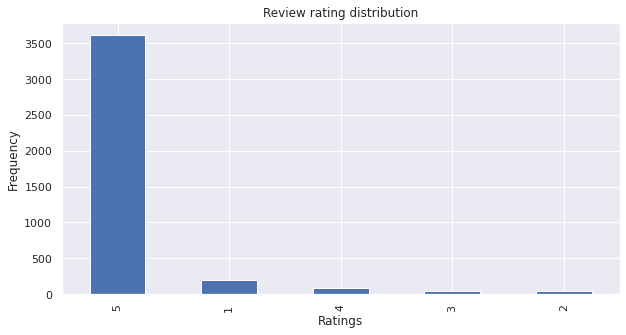

In [ ]:
dataset['ReviewRatings(5)'].value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("Review rating distribution")
plt.ylabel('Frequency')
plt.xlabel('Ratings');

The histogram shows that ratings of 5 stars are the most common in our dataset, followed by ratings of 1 star, 4 stars, 3 stars, and finally 2 stars. As a result, it is possible to conclude that this is an excellent company.

### Reviewers distribution based on Country of origin

Under this let see the distribution of the review based on their country of origin.

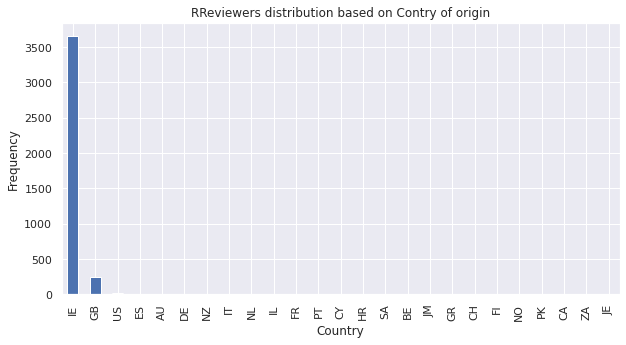

In [ ]:
dataset['Country'].value_counts().nlargest(40).plot(kind='bar', figsize=(10,5))
plt.title("RReviewers distribution based on Contry of origin")
plt.ylabel('Frequency')
plt.xlabel('Country');

The above histogram shows that the majority of the reviewers are Irish, followed by British, with the remainder coming from other countries, albeit in very small numbers.

### Checking Review title length

In [ ]:
dataset['review_len'] = dataset['ReviewTitles'].astype(str).apply(len)
dataset['word_count'] = dataset['ReviewTitles'].apply(lambda x: len(str(x).split()))

dataset.head()

,CustomerName,Country,ReviewCount,ReviewDate,ReviewRatings(5),ReviewTitles,ReviewBody,review_len,word_count
0,Belle Condron,IE,1,2022-12-10,5,Speedy delivery,Speedy delivery. Very friendly and thoughtful ...,15,2
1,Regina Rochford,IE,1,2022-12-10,4,Ordered my item yesterday and it was…,Ordered my item yesterday and it was delivered...,37,7
2,Niamh,IE,7,2022-12-02,2,Collection didn't happen on the day…,Collection didn't happen on the day that was a...,36,6
3,Margaret Hayes,IE,5,2022-12-10,5,Totally dependable,I receive numerous packages from various retai...,18,2
4,Jenny,IE,1,2022-11-07,3,Text message saying what time the…,Text message saying what time the driver will ...,34,6


From the output above tit is possible to count the length of the review titles as well as their word counts and added the results to two different columns at the end of our dataframe.

### Correcting Spelling Mistakes

Whenever it comes to `NLP`, it's best to use data that is free of `spelling errors`, especially in the columns used for sentiment analysis. As a result, because the `ReviewTitles` column is the best feature to be likely used to determine sentiment polarity, then its good to correct the spelling errors in it.

In [ ]:
dataset['ReviewTitles'].apply(lambda x: str(TextBlob(x).correct()))
dataset['ReviewTitles'].head()

0                          Speedy delivery
1    Ordered my item yesterday and it was…
2     Collection didn't happen on the day…
3                       Totally dependable
4       Text message saying what time the…
Name: ReviewTitles, dtype: string

### Adding a Polarity Column

There is one more column under this subsection called `polarity`. `Polarity` conveys the `sentiment` of a text. It helps determine the polarity by counting the both `positive` and `negative` words. The value ranges from `-1` to `1`, with `-1` representing negative sentiment, `0` `neutral`, as well as `1` positive sentiment.

In [ ]:
dataset['polarity'] = dataset['ReviewTitles'].map(lambda text: TextBlob(text).sentiment.polarity)
dataset.tail()

,CustomerName,Country,ReviewCount,ReviewDate,ReviewRatings(5),ReviewTitles,ReviewBody,review_len,word_count,polarity
3975,Anon,IE,2,2022-11-26,5,Declan very friendly & helpful as…,Declan very friendly & helpful as always. Than...,34,6,0.4875
3976,Ciara McStay,IE,5,2022-11-26,5,Fast reliable friendly,Clyton had been delivering in our area for a f...,22,3,0.2875
3977,Carolina Santos,IE,2,2022-11-25,5,I always have good experiences…,I always have good experiences with DPD. Quite...,31,5,0.7000
3978,Rachel Anderson,IE,1,2022-11-24,5,Thoughtful delivery man,Driver had the sense to check if kids were hom...,23,3,0.4000
3979,Joanna OBrien,IE,2,2022-11-26,5,Very efficient and friendly driver,NaN,34,5,0.2875


From there it's good to check the distribution of the three new columns, `review_len`, `word_count`, and `polarity`.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1629a917c0>,
      dtype=object)

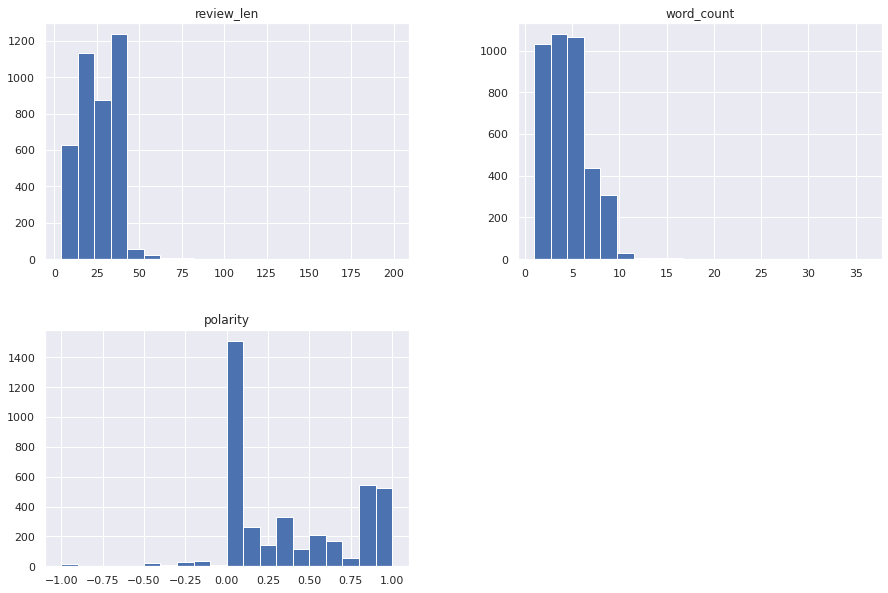

In [ ]:
dataset[["review_len", "word_count", "polarity"]].hist(bins=20, figsize=(15, 10))

As expected, the distribution of review length and word counts is somehow similar. The majority of the population falls into the lower range distribution of the histogram. The distribution is skewed heavily to the right for the word count, while review length distribution is somewhat near normal distribution. Polarity is almost expected. The polarity of the majority is greater than zero. That means that the majority of the reviews are positive.

### Length of the Review vs the Rating

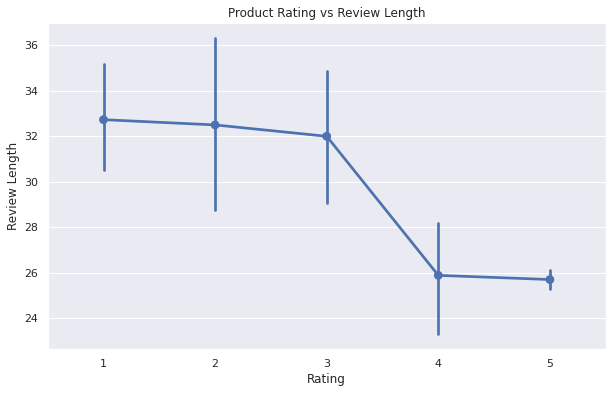

In [ ]:
plt.figure(figsize=(10, 6))
sns.pointplot(x = "ReviewRatings(5)", y = "review_len", data = dataset)
plt.xlabel("Rating")
plt.ylabel("Review Length")
plt.title("Product Rating vs Review Length")
plt.show()

Whenever the overall score is 5, the length of the review is significantly reduced. So, once clients seemed to be pleased, they didn't write a lot!

###  Final Shape of the dataset

In [ ]:
dataset.shape

(3975, 10)

Finally, three more columns were added to the original dataset in order to improve knowledge of the dataset.

### Generating `CSV file` from the dataset

Because there is now a clean dataset, the dataframe can be used to generate a CSV file.

In [ ]:
dataset.to_csv('CA2_Nelson_Gikonyo_Kamau_10621893_hotel_reviews.csv', sep='\t', encoding='utf-8')

## **Conclusion**



To conclude the project, it is appropriate to state that based on the polarity of the review titles, it is possible to conclude that the majority of DPD Ireland's customers are satisfied with their services based on the reviews collected from the "ie.trustpilot.com" website.

Aside from that, it is possible to conclude with certainty that the data is suitable for use in other natural language processing models for different project objectives, with minor modifications.

## **References**

Kumari, S., Mathesul, S., Rambhad, A., & Momin, A. (2022). TrueReview—A Review Scraper and Analyzer for Customer Product Reviews for E-commerce Sites using Text Mining. In Proceeding of International Conference on Computational Science and Applications (pp. 53-63). Springer, Singapore.

Sahu, S., Divya, K., Rastogi, N., Yadav, P. K., & Perwej, Y. Sentimental Analysis on Web Scraping Using Machine Learning Method. Journal of Information and Computational Science (JOICS), ISSN, 1548-7741.